In [392]:
# Importing Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix

import kerastuner as kt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import one_hot
from keras.layers import Dense, Dropout, BatchNormalization, InputLayer


# Data Preparation

In [522]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [238]:
df_train

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...,...
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0


### Null Value Check

In [207]:
print("NaN Details for TRAIN data\n{}".format(df_train.isnull().sum()))
print("\n\nNaN Details for TEST data\n{}".format(df_test.isnull().sum()))

NaN Details for TRAIN data
ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64


NaN Details for TEST data
ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64


In [523]:
# Replace NaN values with 'unk_credit' for data analysis

df_train['Credit_Product'] = df_train['Credit_Product'].replace(np.nan, 'unk_credit')
df_test['Credit_Product'] = df_test['Credit_Product'].replace(np.nan, 'unk_credit')

In [312]:
# Or DROP NaN Values

df_train = df_train.dropna().reset_index(drop=True)
df_test = df_test.dropna().reset_index(drop=True)

### Duplicate Check

In [206]:
print("Duplicate entries in TRAIN data\n{}".format(df_train.duplicated().value_counts()))
print("\n\nDuplicate entries in TEST data\n{}".format(df_test.duplicated().value_counts()))

Duplicate entries in TRAIN data
False    245725
dtype: int64


Duplicate entries in TEST data
False    105312
dtype: int64


# EDA

In [532]:
def uni_graph(train, x, Response):
    """This function will print the univariate analysis with respect to response"""
    a = train[x][train[Response]==0]
    b = train[x][train[Response]==1]
    c = len(set(train[x].value_counts()))

    labels = train[x].value_counts().keys()
    interested = a.value_counts().values
    not_interested = b.value_counts().values
  
    if c < 10:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig, ax = plt.subplots(figsize=(20, 10))
    ax.bar(labels, interested,  label='Not_interested')
    ax.bar(labels, not_interested, bottom=interested, label='Interested')

    plt.xlabel(x)
    plt.ylabel('Count of each ' +x)
    plt.title('Percentage of interested lead vs ' + x)
    plt.legend()

    for rect in ax.patches[c:]:
        i=0
        height = rect.get_height()
        per = 100*height/(height + ax.patches[i].get_height())
        ypos = rect.get_y() + height/2
        total_per = 100*height/train.shape[0]
        ax.text(rect.get_x() + rect.get_width()/2., ypos,
                '%d' % int(per)+'%', ha='center', va='bottom')
        ax.text(rect.get_x() + rect.get_width()/2., ypos + height/2,
                '%d' % int(total_per)+'%', ha='center', va='bottom')
        i+=1

    plt.show()
    print('Total {} unique values are present in the {} column.'.format(c, x))
    print(f'Unique Values are " {labels.values} "')

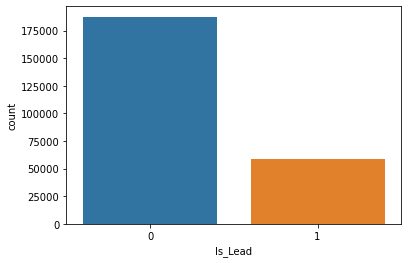

In [224]:
# Dependent Variable Is_Lead

sns.countplot(x=df_train.Is_Lead)
plt.show()

* #### Data distribution dominated by 'not_interested' class

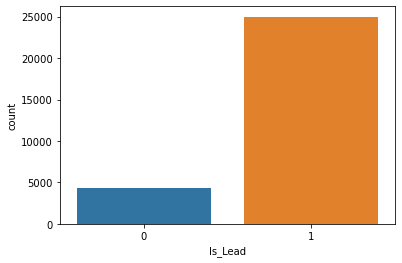

In [225]:
# Leads count whose dependent variable values is NaN in the given Data

sns.countplot(x=df[df_train.Credit_Product.isnull()].Is_Lead)
plt.show()

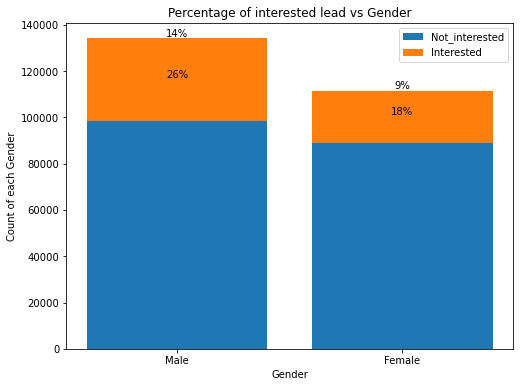

Total 2 unique values are present in the Gender column.
Unique Values are " ['Male' 'Female'] "


In [533]:
# Gender

uni_graph(df_train, 'Gender', 'Is_Lead')

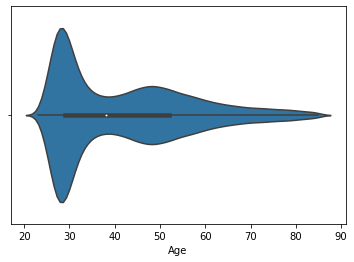

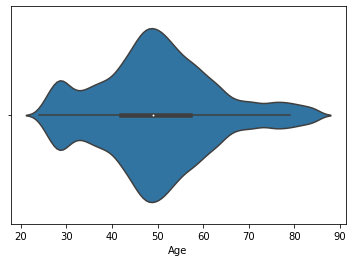

In [226]:
# Age

plt.figure()
sns.violinplot(x='Age', data=df_train[df_train.Is_Lead == 0])
plt.show()

plt.figure()
sns.violinplot(x='Age', data=df_train[df_train.Is_Lead == 1])
plt.show()

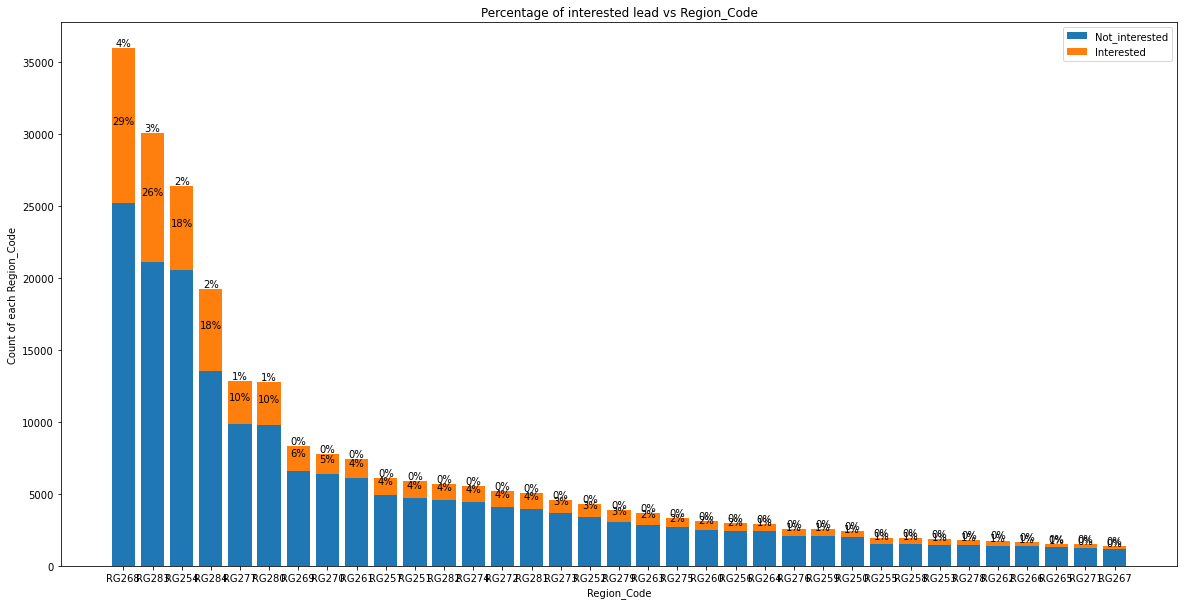

Total 35 unique values are present in the Region_Code column.
Unique Values are " ['RG268' 'RG283' 'RG254' 'RG284' 'RG277' 'RG280' 'RG269' 'RG270' 'RG261'
 'RG257' 'RG251' 'RG282' 'RG274' 'RG272' 'RG281' 'RG273' 'RG252' 'RG279'
 'RG263' 'RG275' 'RG260' 'RG256' 'RG264' 'RG276' 'RG259' 'RG250' 'RG255'
 'RG258' 'RG253' 'RG278' 'RG262' 'RG266' 'RG265' 'RG271' 'RG267'] "


In [227]:
# Region Code

uni_graph(df_train, 'Region_Code', 'Is_Lead')

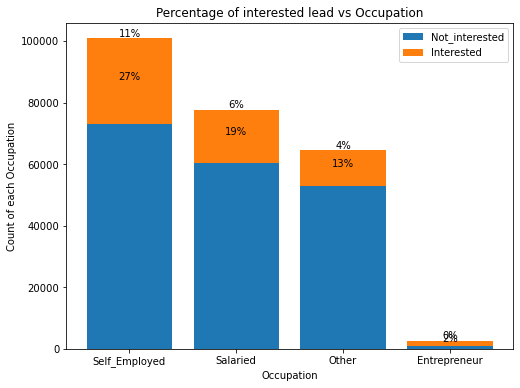

Total 4 unique values are present in the Occupation column.
Unique Values are " ['Self_Employed' 'Salaried' 'Other' 'Entrepreneur'] "


In [228]:
# Occupation

uni_graph(df_train, 'Occupation', 'Is_Lead')

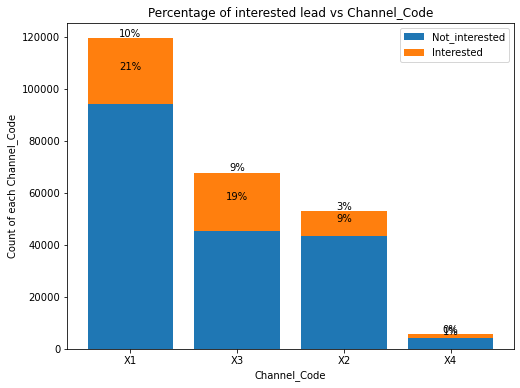

Total 4 unique values are present in the Channel_Code column.
Unique Values are " ['X1' 'X3' 'X2' 'X4'] "


In [229]:
# Channel Code

uni_graph(df_train, 'Channel_Code', 'Is_Lead')

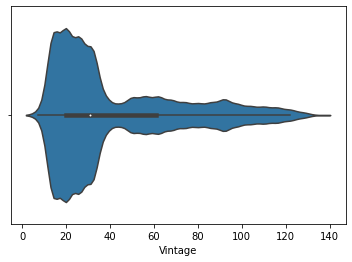

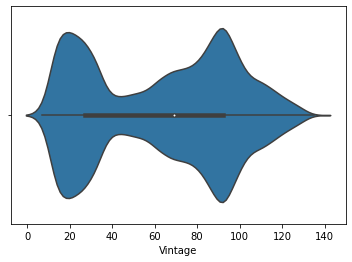

In [230]:
# Vintage

plt.figure()
sns.violinplot(x='Vintage', data=df_train[df_train.Is_Lead == 0])
plt.show()

plt.figure()
sns.violinplot(x='Vintage', data=df_train[df_train.Is_Lead == 1])
plt.show()

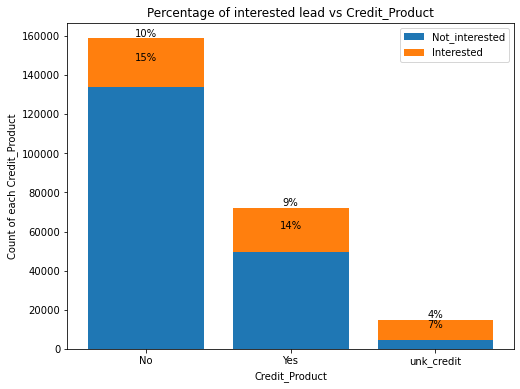

Total 3 unique values are present in the Credit_Product column.
Unique Values are " ['No' 'Yes' 'unk_credit'] "


In [531]:
# Credit Product

uni_graph(df_train, 'Credit_Product', 'Is_Lead')

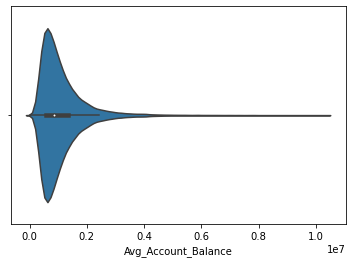

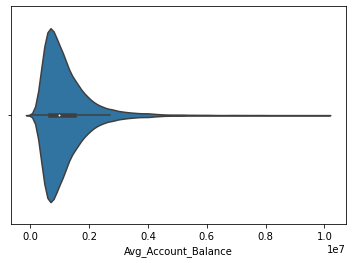

In [232]:
# Average Account Balance

plt.figure()
sns.violinplot(x='Avg_Account_Balance', data=df_train[df_train.Is_Lead == 0])
plt.show()

plt.figure()
sns.violinplot(x='Avg_Account_Balance', data=df_train[df_train.Is_Lead == 1])
plt.show()

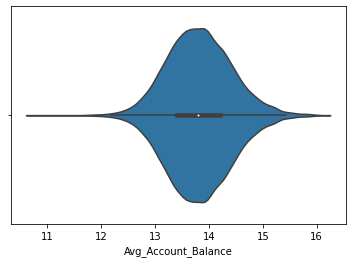

In [538]:
plt.figure()
sns.violinplot(x=np.log(df_train[df_train.Is_Lead == 1].Avg_Account_Balance))
plt.show()

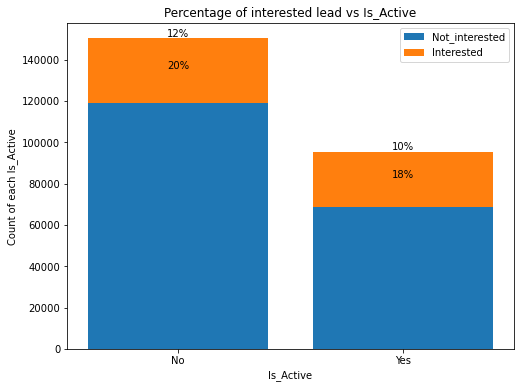

Total 2 unique values are present in the Is_Active column.
Unique Values are " ['No' 'Yes'] "


In [233]:
# Credit Product

uni_graph(df_train, 'Is_Active', 'Is_Lead')

# Preprocessing

In [322]:
# TBD : Try Gender with 1 and 2

def preprocess(data_in):
    '''This function will process the dataframe columnwise fit to be sent for modelling'''
    
    data_in = data_in.dropna().reset_index(drop=True)      # This is to ensure the sent data is clean. 
                                                           # NaN processing should be done outside this function.
    scaler = StandardScaler()
    data_out = pd.DataFrame(data_in['ID'])
    
    data_out['Gender'] = data_in.Gender.replace(\
                    {'Female':1, 'Male':0})                # Encoding Gender 
    
    data_out['Age'] = scaler.fit_transform(\
                    data_in.Age.values.reshape(-1,1))      # Normalizing Age with mean=0 and SD=1
    
    data_out = pd.concat([data_out, pd.get_dummies(\
                    data_in.Occupation, drop_first=True)], axis=1)
    
    data_out = pd.concat([data_out, pd.get_dummies(\
                    data_in.Channel_Code, drop_first=True)], axis=1)
    
    data_out['Vintage'] = scaler.fit_transform(data_in.Vintage.values.reshape(-1,1))
    
    data_out = pd.concat([data_out, pd.get_dummies(\
                    data_in.Credit_Product, drop_first=True)], axis=1)
    
    data_out['Avg_Account_Balance'] = scaler.fit_transform(\
                    data_in.Avg_Account_Balance.values.reshape(-1,1))
    
    data_out = pd.concat([data_out, pd.get_dummies(\
                    data_in.Is_Active, drop_first=True)], axis=1)
    
    data_out = pd.concat([data_out, pd.get_dummies(\
                    data_in.Region_Code, drop_first=True)], axis=1)
    
    return data_out.drop(['ID'], axis=1)

 # Modelling

In [ ]:
# relu was better than elu
# Dropout improved performance


In [475]:
X = preprocess(df_train)
y = df_train.Is_Lead

In [536]:
max(X.Vintage)

2.721252079603235

In [480]:
# Optimizer with custom learning rate

_optimizer = Adam(learning_rate=0.0001)

In [477]:
model = Sequential()
# model.add(Dense(len(X.columns), input_dim=len(X.columns), activation='relu'))
model.add(InputLayer(input_shape=(len(X.columns),)))
for i in range(8):
    model.add(Dense(256, activation='relu', kernel_initializer="he_normal"))
    model.add(Dropout(0.1))
    
model.add(Dense(128, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_initializer="he_normal"))
model.add(Dense(1, activation='sigmoid'))

In [481]:
model.compile(loss='binary_crossentropy', optimizer=_optimizer, metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 256)               12288     
_________________________________________________________________
dropout_137 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_182 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_138 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_183 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_139 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_184 (Dense)            (None, 256)             

In [479]:
model.fit(X, y, epochs=15, batch_size=10000) # validation_split=0.2

Epoch 1/15
25/25 [==============================] - 16s 546ms/step - loss: 0.5403 - auc_20: 0.6434
Epoch 2/15
25/25 [==============================] - 13s 531ms/step - loss: 0.3862 - auc_20: 0.8433
Epoch 3/15
25/25 [==============================] - 13s 527ms/step - loss: 0.3693 - auc_20: 0.8549
Epoch 4/15
25/25 [==============================] - 13s 517ms/step - loss: 0.3637 - auc_20: 0.8593
Epoch 5/15
25/25 [==============================] - 13s 520ms/step - loss: 0.3585 - auc_20: 0.8638
Epoch 6/15
25/25 [==============================] - 13s 525ms/step - loss: 0.3561 - auc_20: 0.8638
Epoch 7/15
25/25 [==============================] - 13s 529ms/step - loss: 0.3541 - auc_20: 0.8652
Epoch 8/15
25/25 [==============================] - 13s 520ms/step - loss: 0.3521 - auc_20: 0.8674
Epoch 9/15
25/25 [==============================] - 13s 528ms/step - loss: 0.3515 - auc_20: 0.8673
Epoch 10/15
25/25 [==============================] - 13s 523ms/step - loss: 0.3511 - auc_20: 0.8675
Epoch 11/

In [516]:
model.fit(X, y, epochs=5, batch_size=5000) # validation_split=0.2

Epoch 1/5
50/50 [==============================] - 16s 329ms/step - loss: 0.3423 - auc_21: 0.8760
Epoch 2/5
50/50 [==============================] - 17s 337ms/step - loss: 0.3421 - auc_21: 0.8763
Epoch 3/5
50/50 [==============================] - 17s 335ms/step - loss: 0.3424 - auc_21: 0.8759
Epoch 4/5
50/50 [==============================] - 17s 331ms/step - loss: 0.3417 - auc_21: 0.8767
Epoch 5/5
50/50 [==============================] - 16s 325ms/step - loss: 0.3420 - auc_21: 0.8764


In [519]:
# Output CSV file

test = pd.concat([df_test.ID, pd.DataFrame(model.predict(preprocess(df_test)))], axis=1)
test.to_csv(path_or_buf='/home/np/out.csv',index=False, header=['ID', 'Is_Lead'])

In [517]:
y_true=df_train.Is_Lead
y_pred = model.predict(preprocess(df_train))
y_pred = np.round(y_pred)

In [518]:
# For 87% AUC

confusion_matrix(y_true=df_train.Is_Lead, y_pred=np.squeeze(y_pred))

array([[178932,   8505],
       [ 24914,  33374]])

In [316]:
# For 80% AUC

confusion_matrix(y_true=df_train.Is_Lead, y_pred=np.squeeze(y_pred))

array([[181478,   1609],
       [ 28317,   4996]])